In [1]:
from google.colab import drive
drive.mount('/content/drive')

# revise this. Make the current working directory to where the repository is (in your google drive)
%cd drive/MyDrive/22FallDeepLearning

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1gd8dbNoPDs7mz9fHUEqBie3e8BG3m36K/22FallDeepLearning


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import gc

In [3]:
from models import * 

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
summary(ResNet18().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
# I modified the ResNet-18 model by making all the number of channels to 1/2

class ModifiedResNetLarge(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNetLarge, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
modified_model_large = ModifiedResNetLarge(BasicBlock, [2, 2, 2, 2])

In [ ]:
summary(modified_model_large.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
# I modified the ResNet-18 model by making all the number of channels to 1/2

class ModifiedResNet3Layers(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet3Layers, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
modified_model_3_layer = ModifiedResNet3Layers(BasicBlock, [2, 2, 2])

In [ ]:
summary(modified_model_3_layer.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 16, 16]          36,864
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]           4,096
       BatchNorm2d-8           [-1, 64, 16, 16]             128
        BasicBlock-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,864
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
       BasicBlock-14           [-1, 64,

In [ ]:
# I modified the ResNet-18 model by making all the number of channels to 1/2

class ModifiedResNetSmall(nn.Module):
# class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNetSmall, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
modified_model_small = ModifiedResNetSmall(BasicBlock, [2, 2, 2, 2])

In [ ]:
summary(modified_model_small.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

# Load data

In [ ]:
import sklearn

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test) # download the train set with test transform as the validation set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(modified_model_small.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# training

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Training
def train(epoch, model, trainloader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(trainloader), total=len(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return train_loss/(batch_idx+1), 100.*correct/total

In [ ]:
def test(epoch, model, testloader, fold = None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    
    return test_loss/(batch_idx+1), acc

In [ ]:
def train(epoch, model, trainloader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(trainloader), total=len(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return train_loss/(batch_idx+1), 100.*correct/total

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
import numpy as np

def Kfold_training(N_EPOCHS, model_num, N_FOLD=5, lr=0.1, isTest=False):

  # make the directory for storing checkpoint
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')

  # Do k-fold cross validation
  splits = KFold(n_splits = N_FOLD, shuffle = True)

  if isTest:
    dataset_len = 1000
  else:
    dataset_len = len(trainset)

  avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc = [0]*N_EPOCHS, [0]*N_EPOCHS, [0]*N_EPOCHS, [0]*N_EPOCHS
  for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(dataset_len))):
    gc.collect()
    torch.cuda.empty_cache()
    print('Fold {}'.format(fold + 1))
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=train_sampler)
    validloader = torch.utils.data.DataLoader(validset, batch_size=100, sampler=valid_sampler)

    if (model_num == 1):
      model = ModifiedResNetLarge(BasicBlock, [2, 2, 2, 2])
      print("large model used")
    elif (model_num == 2):
      model = ModifiedResNetSmall(BasicBlock, [2, 2, 2, 2])
      print("small model used")
    else:
      model = ModifiedResNet3Layers(BasicBlock, [2, 2, 2])
      print("3 layer model used")
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

    for epoch in range(N_EPOCHS):
      start_time = time.time()
      train_loss, train_acc = train(epoch, model, trainloader, optimizer)
      valid_loss, valid_acc = test(epoch, model, validloader, fold+1)
      avg_train_loss[epoch] += train_loss / N_FOLD
      avg_valid_loss[epoch] += valid_loss / N_FOLD
      avg_train_acc[epoch] += train_acc / N_FOLD
      avg_valid_acc[epoch] += valid_acc / N_FOLD
      scheduler.step()
      end_time = time.time()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      print(f'lr={scheduler.get_last_lr()}')
      print(f'Epoch: {epoch+1} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f"epoch{epoch+1} train loss: {train_loss} train acc: {train_acc} valid acc: {valid_acc}")

  return avg_train_loss, avg_train_acc, avg_valid_loss, avg_valid_acc

In [ ]:
small_train_loss, small_train_acc, small_valid_loss, small_valid_acc = Kfold_training(30, 2, N_FOLD=5)
print(small_train_loss)
print(small_train_acc)
print(small_valid_loss)
print(small_valid_acc)

Fold 1
small model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.7625562969488078 train acc: 34.1125 valid acc: 44.11


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 31s
epoch2 train loss: 1.3478642938236078 train acc: 51.075 valid acc: 53.53


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 31s
epoch3 train loss: 1.0844135789063791 train acc: 61.095 valid acc: 55.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 30s
epoch4 train loss: 0.9009209857962002 train acc: 68.085 valid acc: 68.87


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 31s
epoch5 train loss: 0.7635339475668277 train acc: 73.295 valid acc: 69.74


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 31s
epoch6 train loss: 0.6799249975635602 train acc: 76.3975 valid acc: 74.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 30s
epoch7 train loss: 0.6183839415589841 train acc: 78.7975 valid acc: 76.73


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 31s
epoch8 train loss: 0.57346379223723 train acc: 80.285 valid acc: 79.66


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 31s
epoch9 train loss: 0.5459081054495546 train acc: 81.255 valid acc: 77.96


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 30s
epoch10 train loss: 0.5147637684886067 train acc: 82.0925 valid acc: 77.56


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 31s
epoch11 train loss: 0.49128821834969444 train acc: 83.2225 valid acc: 80.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 32s
epoch12 train loss: 0.46085368053981673 train acc: 84.085 valid acc: 82.23


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 31s
epoch13 train loss: 0.43539723611106507 train acc: 84.9525 valid acc: 81.68


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 30s
epoch14 train loss: 0.41576762145129254 train acc: 85.555 valid acc: 82.04


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 31s
epoch15 train loss: 0.3893419718399596 train acc: 86.6 valid acc: 84.03


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 31s
epoch16 train loss: 0.36244578073961664 train acc: 87.6875 valid acc: 84.33


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 30s
epoch17 train loss: 0.3436305428179689 train acc: 88.0475 valid acc: 79.57


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 31s
epoch18 train loss: 0.31772406384967766 train acc: 88.9825 valid acc: 83.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 31s
epoch19 train loss: 0.29179951658073705 train acc: 90.0 valid acc: 86.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 30s
epoch20 train loss: 0.26419712795902744 train acc: 90.845 valid acc: 85.55


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 31s
epoch21 train loss: 0.23329288074478935 train acc: 92.0075 valid acc: 87.31


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 32s
epoch22 train loss: 0.2118476254585833 train acc: 92.7875 valid acc: 88.46


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 31s
epoch23 train loss: 0.180148582691297 train acc: 93.825 valid acc: 89.38


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 31s
epoch24 train loss: 0.15299987778686486 train acc: 94.82 valid acc: 89.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 31s
epoch25 train loss: 0.12629695393192691 train acc: 95.6725 valid acc: 90.11


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 30s
epoch26 train loss: 0.10690622157848681 train acc: 96.4725 valid acc: 90.64


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 31s
epoch27 train loss: 0.08975502645102934 train acc: 97.0875 valid acc: 91.23


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 31s
epoch28 train loss: 0.07562091909706022 train acc: 97.57 valid acc: 91.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 31s
epoch29 train loss: 0.06786212661324408 train acc: 97.945 valid acc: 91.31


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 31s
epoch30 train loss: 0.062253486109189335 train acc: 98.1075 valid acc: 91.47
Fold 2
small model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.794265781347744 train acc: 33.175 valid acc: 42.12


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 31s
epoch2 train loss: 1.402640289011093 train acc: 48.2875 valid acc: 55.78


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 32s
epoch3 train loss: 1.1218333436658208 train acc: 59.605 valid acc: 51.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 32s
epoch4 train loss: 0.9360263579950546 train acc: 66.9175 valid acc: 55.03


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 32s
epoch5 train loss: 0.7890732450226244 train acc: 72.2475 valid acc: 70.15


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 32s
epoch6 train loss: 0.6899255488436824 train acc: 75.965 valid acc: 65.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 31s
epoch7 train loss: 0.6260823090426838 train acc: 78.2325 valid acc: 74.99


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 31s
epoch8 train loss: 0.5814763391360688 train acc: 80.01 valid acc: 77.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 31s
epoch9 train loss: 0.5486359542931992 train acc: 80.8975 valid acc: 76.12


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 31s
epoch10 train loss: 0.5159320276194868 train acc: 82.1275 valid acc: 76.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 31s
epoch11 train loss: 0.48813439158205024 train acc: 83.09 valid acc: 76.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 31s
epoch12 train loss: 0.4621283789031422 train acc: 84.065 valid acc: 76.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 32s
epoch13 train loss: 0.44090965337837085 train acc: 84.8875 valid acc: 82.35


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 31s
epoch14 train loss: 0.4136633842993087 train acc: 85.78 valid acc: 81.68


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 31s
epoch15 train loss: 0.38871769211924495 train acc: 86.6975 valid acc: 80.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 31s
epoch16 train loss: 0.3614738723530937 train acc: 87.495 valid acc: 82.75


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 32s
epoch17 train loss: 0.3392089413949095 train acc: 88.385 valid acc: 84.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 31s
epoch18 train loss: 0.31017020749398316 train acc: 89.135 valid acc: 84.87


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 31s
epoch19 train loss: 0.2923583248838449 train acc: 89.825 valid acc: 85.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 31s
epoch20 train loss: 0.2636740328119205 train acc: 90.9525 valid acc: 86.88


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 30s
epoch21 train loss: 0.23712652233747628 train acc: 91.7575 valid acc: 86.27


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 31s
epoch22 train loss: 0.21296761532465872 train acc: 92.5825 valid acc: 88.19


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 31s
epoch23 train loss: 0.17912105658945565 train acc: 93.93 valid acc: 88.48


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 31s
epoch24 train loss: 0.15183474071109637 train acc: 94.8925 valid acc: 89.35


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 31s
epoch25 train loss: 0.12914298608684882 train acc: 95.6325 valid acc: 89.42


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 31s
epoch26 train loss: 0.10858679897250079 train acc: 96.365 valid acc: 90.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 31s
epoch27 train loss: 0.08914057819392925 train acc: 97.0575 valid acc: 90.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 31s
epoch28 train loss: 0.07847294344688757 train acc: 97.4575 valid acc: 90.84


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 32s
epoch29 train loss: 0.07059136097923445 train acc: 97.72 valid acc: 91.09


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 31s
epoch30 train loss: 0.06622291960940956 train acc: 97.9025 valid acc: 91.14
Fold 3
small model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 30s
epoch1 train loss: 1.7911368806522114 train acc: 33.725 valid acc: 44.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 31s
epoch2 train loss: 1.3752163519112828 train acc: 49.75 valid acc: 55.35


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 31s
epoch3 train loss: 1.1054341461711799 train acc: 60.425 valid acc: 63.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 32s
epoch4 train loss: 0.9253203427067961 train acc: 67.06 valid acc: 65.35


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 31s
epoch5 train loss: 0.7988705886438632 train acc: 71.8025 valid acc: 61.63


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 31s
epoch6 train loss: 0.698018512025047 train acc: 75.4975 valid acc: 66.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 31s
epoch7 train loss: 0.6309531426277405 train acc: 77.8525 valid acc: 75.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 31s
epoch8 train loss: 0.5866306258466678 train acc: 79.615 valid acc: 77.38


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 31s
epoch9 train loss: 0.5501127605811476 train acc: 81.165 valid acc: 74.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 32s
epoch10 train loss: 0.5112574936482853 train acc: 82.3475 valid acc: 75.85


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 31s
epoch11 train loss: 0.4946382378998656 train acc: 82.795 valid acc: 76.84


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 31s
epoch12 train loss: 0.46245161032143495 train acc: 83.9775 valid acc: 77.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 31s
epoch13 train loss: 0.4404688923598859 train acc: 84.945 valid acc: 76.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 30s
epoch14 train loss: 0.4134262837350559 train acc: 85.76 valid acc: 82.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 31s
epoch15 train loss: 0.39326537917025933 train acc: 86.4575 valid acc: 82.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 33s
epoch16 train loss: 0.3626888645723605 train acc: 87.4525 valid acc: 83.34


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 31s
epoch17 train loss: 0.33611142454436793 train acc: 88.42 valid acc: 82.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 31s
epoch18 train loss: 0.3158065841649287 train acc: 89.1525 valid acc: 86.09


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 31s
epoch19 train loss: 0.2911484764216426 train acc: 89.84 valid acc: 83.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 31s
epoch20 train loss: 0.26549329325413934 train acc: 90.75 valid acc: 86.98


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 32s
epoch21 train loss: 0.23607036933160055 train acc: 91.86 valid acc: 87.23


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 33s
epoch22 train loss: 0.21053859215384474 train acc: 92.74 valid acc: 88.2


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 31s
epoch23 train loss: 0.1805942394910529 train acc: 93.7 valid acc: 88.92


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 31s
epoch24 train loss: 0.15407373220585405 train acc: 94.6675 valid acc: 89.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 32s
epoch25 train loss: 0.12800363333413775 train acc: 95.62 valid acc: 90.91


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 31s
epoch26 train loss: 0.10545641840837253 train acc: 96.4125 valid acc: 90.65


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 31s
epoch27 train loss: 0.08940456548747354 train acc: 97.065 valid acc: 91.11


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 32s
epoch28 train loss: 0.07665743380070875 train acc: 97.5875 valid acc: 91.7


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 31s
epoch29 train loss: 0.06812824000018283 train acc: 97.8675 valid acc: 91.9


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 31s
epoch30 train loss: 0.06562484059328089 train acc: 97.995 valid acc: 91.87
Fold 4
small model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.8987609182302945 train acc: 29.7075 valid acc: 37.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 31s
epoch2 train loss: 1.4735265844546186 train acc: 45.8875 valid acc: 50.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 31s
epoch3 train loss: 1.2261287503349134 train acc: 56.0775 valid acc: 55.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 33s
epoch4 train loss: 1.04203577944265 train acc: 63.15 valid acc: 57.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 32s
epoch5 train loss: 0.914612554132748 train acc: 67.76 valid acc: 68.3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 31s
epoch6 train loss: 0.7993103442862391 train acc: 71.99 valid acc: 71.18


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 32s
epoch7 train loss: 0.6955377629961068 train acc: 75.77 valid acc: 62.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 32s
epoch8 train loss: 0.6334464021574575 train acc: 78.13 valid acc: 74.09


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 32s
epoch9 train loss: 0.5838476291860635 train acc: 79.635 valid acc: 77.12


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 32s
epoch10 train loss: 0.5527568587099021 train acc: 80.6425 valid acc: 80.75


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 32s
epoch11 train loss: 0.5199436743419391 train acc: 82.2225 valid acc: 77.42


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 32s
epoch12 train loss: 0.4926518102804312 train acc: 82.8625 valid acc: 81.65


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 31s
epoch13 train loss: 0.4625402534731661 train acc: 83.8975 valid acc: 78.04


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 32s
epoch14 train loss: 0.4332770713316366 train acc: 84.985 valid acc: 83.02


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 33s
epoch15 train loss: 0.41036072173438515 train acc: 85.8725 valid acc: 84.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 31s
epoch16 train loss: 0.385694073221554 train acc: 86.6475 valid acc: 85.12


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 32s
epoch17 train loss: 0.35741427293219885 train acc: 87.63 valid acc: 84.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 32s
epoch18 train loss: 0.32704279821711224 train acc: 88.81 valid acc: 85.91


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 32s
epoch19 train loss: 0.30795796144122894 train acc: 89.1575 valid acc: 86.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 31s
epoch20 train loss: 0.27479057954237485 train acc: 90.38 valid acc: 86.78


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 33s
epoch21 train loss: 0.24852555204694643 train acc: 91.3325 valid acc: 88.56


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 32s
epoch22 train loss: 0.22208384629160452 train acc: 92.37 valid acc: 88.96


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 32s
epoch23 train loss: 0.1912585700662753 train acc: 93.3525 valid acc: 89.18


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 31s
epoch24 train loss: 0.16435939909075015 train acc: 94.405 valid acc: 90.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 32s
epoch25 train loss: 0.13993935147746683 train acc: 95.3075 valid acc: 90.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 33s
epoch26 train loss: 0.11498305455635721 train acc: 96.1325 valid acc: 91.04


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 32s
epoch27 train loss: 0.09707790999390638 train acc: 96.7525 valid acc: 91.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 31s
epoch28 train loss: 0.08527818447151504 train acc: 97.22 valid acc: 91.59


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 32s
epoch29 train loss: 0.07574456348753394 train acc: 97.565 valid acc: 91.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 32s
epoch30 train loss: 0.07022092388437008 train acc: 97.8575 valid acc: 91.73
Fold 5
small model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.7826431665938502 train acc: 34.2075 valid acc: 46.89


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 33s
epoch2 train loss: 1.384065534740972 train acc: 49.2525 valid acc: 50.73


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 32s
epoch3 train loss: 1.1162844848708984 train acc: 59.655 valid acc: 63.48


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 32s
epoch4 train loss: 0.9263965982598619 train acc: 67.01 valid acc: 58.18


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 31s
epoch5 train loss: 0.7959920602103773 train acc: 72.2975 valid acc: 69.27


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 32s
epoch6 train loss: 0.6911714342645944 train acc: 75.97 valid acc: 67.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 33s
epoch7 train loss: 0.6274615542385906 train acc: 78.125 valid acc: 77.34


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 32s
epoch8 train loss: 0.5820475856717021 train acc: 79.65 valid acc: 72.32


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 31s
epoch9 train loss: 0.5447261899043196 train acc: 81.195 valid acc: 76.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 32s
epoch10 train loss: 0.5169533778684208 train acc: 82.1875 valid acc: 80.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 32s
epoch11 train loss: 0.4890256481239209 train acc: 83.085 valid acc: 83.01


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 32s
epoch12 train loss: 0.46412227319452326 train acc: 84.0375 valid acc: 76.55


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 32s
epoch13 train loss: 0.4391000751679698 train acc: 84.9825 valid acc: 75.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 32s
epoch14 train loss: 0.4107748997954134 train acc: 85.755 valid acc: 81.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 32s
epoch15 train loss: 0.39318413170762717 train acc: 86.51 valid acc: 79.56


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 31s
epoch16 train loss: 0.3725061737024746 train acc: 87.1 valid acc: 84.68


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 32s
epoch17 train loss: 0.34567507016011323 train acc: 87.9975 valid acc: 83.48


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 33s
epoch18 train loss: 0.31732331044948137 train acc: 89.02 valid acc: 86.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 32s
epoch19 train loss: 0.2901710693638165 train acc: 89.8775 valid acc: 87.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 31s
epoch20 train loss: 0.26389193265868455 train acc: 90.88 valid acc: 87.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 32s
epoch21 train loss: 0.23773290931035918 train acc: 91.775 valid acc: 87.31


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 32s
epoch22 train loss: 0.2096958591724737 train acc: 92.8725 valid acc: 88.59


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 32s
epoch23 train loss: 0.1863074330523753 train acc: 93.5375 valid acc: 89.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 32s
epoch24 train loss: 0.15307200263245418 train acc: 94.685 valid acc: 89.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 31s
epoch25 train loss: 0.13260773417001334 train acc: 95.475 valid acc: 90.16


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 32s
epoch26 train loss: 0.11039862943628725 train acc: 96.245 valid acc: 90.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 32s
epoch27 train loss: 0.09118643901742304 train acc: 97.02 valid acc: 90.99


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 31s
epoch28 train loss: 0.07827625540903392 train acc: 97.505 valid acc: 91.37


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 32s
epoch29 train loss: 0.07155604998524577 train acc: 97.84 valid acc: 91.5


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 32s
epoch30 train loss: 0.06560056055851352 train acc: 98.0075 valid acc: 91.45
[1.8058726087545818, 1.3966626107883147, 1.1308188607898382, 0.9461400128401125, 0.8124164791152881, 0.7116701673966246, 0.6396837420928212, 0.5914129490098252, 0.5546461278828569, 0.5223327052669403, 0.4966060340594941, 0.46844155064786963, 0.4436832220980915, 0.4173818521225414, 0.39497397931429523, 0.3689617529178199, 0.3444080503699117, 0.3176133928350366, 0.294687069738254, 0.26640939324522933, 0.23854964675423435, 0.21342670768023297, 0.18348597637809122, 0.15526795048540393, 0.13119813180007872, 0.10926622459040092, 0.09131290382875229, 0.07886114724504109, 0.07077646821308821, 0.06598454615095267]
[32.9855, 48.8505, 59.3715, 66.4445, 71.48049999999999, 75.164, 77.7555, 79.538, 80.8295, 81.87950000000001, 82.88299999999998, 83.8055, 84.733, 85.567, 86.42750000000001, 87.2765, 88.096, 89.02000000000001, 89.74, 90.7615, 91.74650000000001, 92.6705, 93.669, 94.694, 95.

In [ ]:
large_train_loss, large_train_acc, large_valid_loss, large_valid_acc = Kfold_training(30, 1, N_FOLD=5)
print(large_train_loss)
print(large_train_acc)
print(large_valid_loss)
print(large_valid_acc)

Fold 1
large model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 45s
epoch1 train loss: 1.773042019563742 train acc: 34.39 valid acc: 43.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 45s
epoch2 train loss: 1.3490305621022234 train acc: 50.565 valid acc: 55.01


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 45s
epoch3 train loss: 1.1034323801628698 train acc: 60.9075 valid acc: 60.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 46s
epoch4 train loss: 0.9371967127147954 train acc: 66.745 valid acc: 66.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 45s
epoch5 train loss: 0.8169601011200073 train acc: 71.255 valid acc: 69.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 46s
epoch6 train loss: 0.7001091401797895 train acc: 75.5925 valid acc: 69.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 46s
epoch7 train loss: 0.6306134409988269 train acc: 77.98 valid acc: 72.52


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 46s
epoch8 train loss: 0.5780865615739609 train acc: 79.825 valid acc: 76.15


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 46s
epoch9 train loss: 0.535606225744223 train acc: 81.46 valid acc: 70.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 46s
epoch10 train loss: 0.4998072510519728 train acc: 82.8375 valid acc: 78.08


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 46s
epoch11 train loss: 0.470046892048071 train acc: 84.0525 valid acc: 81.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 46s
epoch12 train loss: 0.43454941064595415 train acc: 85.0225 valid acc: 74.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 46s
epoch13 train loss: 0.419500251976065 train acc: 85.695 valid acc: 81.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 45s
epoch14 train loss: 0.3929493595807316 train acc: 86.535 valid acc: 83.15


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 47s
epoch15 train loss: 0.35983165151204544 train acc: 87.51 valid acc: 83.74


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 46s
epoch16 train loss: 0.3300554312456149 train acc: 88.7125 valid acc: 83.95


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 45s
epoch17 train loss: 0.3087467091818587 train acc: 89.3125 valid acc: 87.38


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 45s
epoch18 train loss: 0.28219740887800343 train acc: 90.14 valid acc: 85.89


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 46s
epoch19 train loss: 0.2502066598008997 train acc: 91.3225 valid acc: 86.98


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 45s
epoch20 train loss: 0.22030740890640038 train acc: 92.3125 valid acc: 87.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 46s
epoch21 train loss: 0.1986301058825974 train acc: 93.1525 valid acc: 88.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 46s
epoch22 train loss: 0.16704988798584802 train acc: 94.2225 valid acc: 89.96


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 46s
epoch23 train loss: 0.14452854172585491 train acc: 95.0225 valid acc: 90.02


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 46s
epoch24 train loss: 0.11493586312039211 train acc: 96.14 valid acc: 90.63


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 45s
epoch25 train loss: 0.08937486663413124 train acc: 97.0325 valid acc: 91.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 46s
epoch26 train loss: 0.06874638979141705 train acc: 97.7625 valid acc: 92.3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 46s
epoch27 train loss: 0.05452920583942637 train acc: 98.29 valid acc: 92.18


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 46s
epoch28 train loss: 0.04364574640489424 train acc: 98.76 valid acc: 92.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 45s
epoch29 train loss: 0.03883321928425719 train acc: 98.94 valid acc: 92.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 46s
epoch30 train loss: 0.03453870177471314 train acc: 99.0625 valid acc: 92.5
Fold 2
large model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 46s
epoch1 train loss: 1.7197875980371105 train acc: 36.655 valid acc: 45.66


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 46s
epoch2 train loss: 1.2779068998254526 train acc: 53.1325 valid acc: 59.86


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 46s
epoch3 train loss: 1.0162823878157252 train acc: 63.68 valid acc: 62.33


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 46s
epoch4 train loss: 0.8614041548186597 train acc: 69.385 valid acc: 66.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 45s
epoch5 train loss: 0.7382877386225679 train acc: 74.0525 valid acc: 67.44


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 46s
epoch6 train loss: 0.6569556307297545 train acc: 77.1575 valid acc: 76.75


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 45s
epoch7 train loss: 0.5921817918935903 train acc: 79.555 valid acc: 78.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 46s
epoch8 train loss: 0.5482722136159294 train acc: 81.0525 valid acc: 77.4


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 45s
epoch9 train loss: 0.5099570884491308 train acc: 82.3975 valid acc: 72.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 45s
epoch10 train loss: 0.4787045794363601 train acc: 83.67 valid acc: 82.44


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 45s
epoch11 train loss: 0.45573869423744395 train acc: 84.37 valid acc: 79.04


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 46s
epoch12 train loss: 0.4228247443136697 train acc: 85.415 valid acc: 79.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 45s
epoch13 train loss: 0.40399114625712934 train acc: 86.0525 valid acc: 83.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 45s
epoch14 train loss: 0.37332981962936757 train acc: 87.09 valid acc: 81.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 45s
epoch15 train loss: 0.35356136604239 train acc: 87.86 valid acc: 83.62


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 46s
epoch16 train loss: 0.3241473337807975 train acc: 88.845 valid acc: 85.91


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 45s
epoch17 train loss: 0.29972603224432126 train acc: 89.77 valid acc: 84.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 45s
epoch18 train loss: 0.2766803238338556 train acc: 90.47 valid acc: 86.53


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 45s
epoch19 train loss: 0.24731093854569017 train acc: 91.47 valid acc: 88.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 46s
epoch20 train loss: 0.22248122315056407 train acc: 92.47 valid acc: 86.89


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 45s
epoch21 train loss: 0.19126014024638138 train acc: 93.4075 valid acc: 89.23


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 46s
epoch22 train loss: 0.16768652951707855 train acc: 94.21 valid acc: 89.84


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 47s
epoch23 train loss: 0.14169868466239005 train acc: 95.1775 valid acc: 90.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 45s
epoch24 train loss: 0.11559760666336305 train acc: 96.045 valid acc: 91.37


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 46s
epoch25 train loss: 0.08641886332045538 train acc: 97.15 valid acc: 91.86


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 46s
epoch26 train loss: 0.07042697965563201 train acc: 97.7125 valid acc: 92.33


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 46s
epoch27 train loss: 0.05529948527784869 train acc: 98.2025 valid acc: 92.73


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 46s
epoch28 train loss: 0.04387739330482559 train acc: 98.745 valid acc: 92.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 46s
epoch29 train loss: 0.038289093394606066 train acc: 98.8475 valid acc: 92.95


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 46s
epoch30 train loss: 0.03591873372247377 train acc: 99.005 valid acc: 93.0
Fold 3
large model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 46s
epoch1 train loss: 1.7530575758352067 train acc: 34.67 valid acc: 43.72


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 46s
epoch2 train loss: 1.3276370906601318 train acc: 51.47 valid acc: 56.08


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 46s
epoch3 train loss: 1.0566763731237419 train acc: 62.22 valid acc: 64.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 46s
epoch4 train loss: 0.8801449344942744 train acc: 68.93 valid acc: 61.32


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 46s
epoch5 train loss: 0.7498138872579264 train acc: 73.715 valid acc: 74.4


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 46s
epoch6 train loss: 0.6613699658610188 train acc: 76.8525 valid acc: 75.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 45s
epoch7 train loss: 0.597127653253726 train acc: 79.2375 valid acc: 76.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 45s
epoch8 train loss: 0.5504970720019965 train acc: 81.05 valid acc: 78.14


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 46s
epoch9 train loss: 0.5108019424893986 train acc: 82.25 valid acc: 76.68


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 46s
epoch10 train loss: 0.472310623897912 train acc: 83.7725 valid acc: 77.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 45s
epoch11 train loss: 0.4559892716880043 train acc: 84.3525 valid acc: 80.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 46s
epoch12 train loss: 0.4310908424206816 train acc: 85.2975 valid acc: 76.06


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 46s
epoch13 train loss: 0.4047470183703846 train acc: 86.2975 valid acc: 78.64


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 45s
epoch14 train loss: 0.3780709183254181 train acc: 86.96 valid acc: 79.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 45s
epoch15 train loss: 0.35396243969853314 train acc: 87.7675 valid acc: 83.44


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 45s
epoch16 train loss: 0.32505811012971897 train acc: 88.8825 valid acc: 83.79


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 46s
epoch17 train loss: 0.30476812889781624 train acc: 89.75 valid acc: 85.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 45s
epoch18 train loss: 0.26780935495901415 train acc: 90.8475 valid acc: 86.72


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 45s
epoch19 train loss: 0.2481284393384434 train acc: 91.505 valid acc: 86.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 46s
epoch20 train loss: 0.22290585251947562 train acc: 92.335 valid acc: 88.56


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 45s
epoch21 train loss: 0.19592257784292721 train acc: 93.2275 valid acc: 87.92


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 45s
epoch22 train loss: 0.1627595512488018 train acc: 94.3375 valid acc: 89.61


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 45s
epoch23 train loss: 0.1409258740826156 train acc: 95.275 valid acc: 89.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 46s
epoch24 train loss: 0.11048320683237083 train acc: 96.31 valid acc: 91.72


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 45s
epoch25 train loss: 0.09116580512243719 train acc: 96.89 valid acc: 91.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 45s
epoch26 train loss: 0.06870173362973399 train acc: 97.7825 valid acc: 91.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 45s
epoch27 train loss: 0.05514854441483181 train acc: 98.2625 valid acc: 92.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 47s
epoch28 train loss: 0.04441853044643855 train acc: 98.6875 valid acc: 92.69


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 46s
epoch29 train loss: 0.03961049043499052 train acc: 98.8775 valid acc: 92.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 46s
epoch30 train loss: 0.036197350259287095 train acc: 98.9925 valid acc: 92.81
Fold 4
large model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 46s
epoch1 train loss: 1.7396636561463816 train acc: 35.895 valid acc: 45.55


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 46s
epoch2 train loss: 1.3026394657433604 train acc: 52.3325 valid acc: 58.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 45s
epoch3 train loss: 1.0366850379176034 train acc: 62.91 valid acc: 65.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 46s
epoch4 train loss: 0.8647084472278437 train acc: 69.3225 valid acc: 68.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 45s
epoch5 train loss: 0.7364047138264385 train acc: 74.1925 valid acc: 67.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 46s
epoch6 train loss: 0.6395002640664768 train acc: 77.6225 valid acc: 72.15


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 45s
epoch7 train loss: 0.5785101565499656 train acc: 80.0325 valid acc: 80.5


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 45s
epoch8 train loss: 0.5375978061185477 train acc: 81.27 valid acc: 77.48


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 46s
epoch9 train loss: 0.5003670609225861 train acc: 82.7275 valid acc: 79.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 46s
epoch10 train loss: 0.46387021105510357 train acc: 84.055 valid acc: 82.7


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 46s
epoch11 train loss: 0.4445117029804772 train acc: 84.795 valid acc: 83.02


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 45s
epoch12 train loss: 0.4164627721896187 train acc: 85.645 valid acc: 82.5


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 45s
epoch13 train loss: 0.400339727203686 train acc: 86.1275 valid acc: 83.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 46s
epoch14 train loss: 0.3678881145132997 train acc: 87.495 valid acc: 78.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 46s
epoch15 train loss: 0.3469055348787064 train acc: 88.065 valid acc: 83.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 46s
epoch16 train loss: 0.32911331513628794 train acc: 88.5725 valid acc: 87.14


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 46s
epoch17 train loss: 0.3009086191273345 train acc: 89.57 valid acc: 85.73


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 46s
epoch18 train loss: 0.27269028638974546 train acc: 90.4175 valid acc: 87.56


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 46s
epoch19 train loss: 0.24395011151179719 train acc: 91.4375 valid acc: 86.89


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 45s
epoch20 train loss: 0.22555296870466238 train acc: 92.215 valid acc: 89.15


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 45s
epoch21 train loss: 0.19080319531714193 train acc: 93.51 valid acc: 88.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 46s
epoch22 train loss: 0.16329758829725816 train acc: 94.4 valid acc: 89.12


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 45s
epoch23 train loss: 0.13402639181850057 train acc: 95.5025 valid acc: 90.65


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 45s
epoch24 train loss: 0.11106986784563659 train acc: 96.225 valid acc: 91.38


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 45s
epoch25 train loss: 0.08708855309806311 train acc: 97.1 valid acc: 91.9


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 47s
epoch26 train loss: 0.06533855233734218 train acc: 97.885 valid acc: 92.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 46s
epoch27 train loss: 0.055534283190180125 train acc: 98.2675 valid acc: 92.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 45s
epoch28 train loss: 0.04377371912744765 train acc: 98.725 valid acc: 92.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 45s
epoch29 train loss: 0.03666137517712558 train acc: 98.9775 valid acc: 92.79


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 46s
epoch30 train loss: 0.03561820961332645 train acc: 98.9925 valid acc: 92.79
Fold 5
large model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 45s
epoch1 train loss: 1.8160298122003817 train acc: 33.8 valid acc: 43.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 45s
epoch2 train loss: 1.3957778207791118 train acc: 48.5575 valid acc: 49.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 45s
epoch3 train loss: 1.1492266333141266 train acc: 58.545 valid acc: 56.29


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 45s
epoch4 train loss: 0.9629347312945528 train acc: 65.6075 valid acc: 61.48


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 46s
epoch5 train loss: 0.8049840631957252 train acc: 71.645 valid acc: 70.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 45s
epoch6 train loss: 0.7004065329845721 train acc: 75.4825 valid acc: 63.31


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 45s
epoch7 train loss: 0.6208625904287393 train acc: 78.4 valid acc: 74.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 45s
epoch8 train loss: 0.5724035155849335 train acc: 80.2075 valid acc: 75.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 46s
epoch9 train loss: 0.531637027526435 train acc: 81.8875 valid acc: 78.31


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 46s
epoch10 train loss: 0.4982073728840191 train acc: 82.9975 valid acc: 79.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 46s
epoch11 train loss: 0.46422929466722873 train acc: 84.09 valid acc: 81.11


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 45s
epoch12 train loss: 0.4372952452863748 train acc: 85.085 valid acc: 80.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 46s
epoch13 train loss: 0.4074366314056963 train acc: 86.2 valid acc: 83.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 45s
epoch14 train loss: 0.38638216447525514 train acc: 86.5875 valid acc: 83.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 45s
epoch15 train loss: 0.36051941379761926 train acc: 87.5025 valid acc: 85.2


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 45s
epoch16 train loss: 0.33314597739960056 train acc: 88.4925 valid acc: 84.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 46s
epoch17 train loss: 0.3078618948452008 train acc: 89.5675 valid acc: 85.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 46s
epoch18 train loss: 0.2763108669902189 train acc: 90.3775 valid acc: 84.42


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 46s
epoch19 train loss: 0.2551493686608994 train acc: 91.175 valid acc: 86.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 46s
epoch20 train loss: 0.2252463558897043 train acc: 92.145 valid acc: 87.06


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 46s
epoch21 train loss: 0.19963538413421034 train acc: 93.1325 valid acc: 88.89


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 46s
epoch22 train loss: 0.17098048541206903 train acc: 94.1525 valid acc: 89.19


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 45s
epoch23 train loss: 0.144448724393837 train acc: 95.035 valid acc: 89.5


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 45s
epoch24 train loss: 0.11504117001931126 train acc: 96.1725 valid acc: 90.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 45s
epoch25 train loss: 0.08916548161080089 train acc: 97.09 valid acc: 91.5


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 46s
epoch26 train loss: 0.07191846384622227 train acc: 97.68 valid acc: 91.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 45s
epoch27 train loss: 0.055896037769988895 train acc: 98.2775 valid acc: 91.96


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 46s
epoch28 train loss: 0.044164900346614494 train acc: 98.765 valid acc: 92.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 46s
epoch29 train loss: 0.040521265629429024 train acc: 98.7925 valid acc: 92.36


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 46s
epoch30 train loss: 0.038527494909378665 train acc: 98.93 valid acc: 92.46
[1.7603161323565644, 1.3305983678220559, 1.0724605624668135, 0.9012777961100253, 0.769290100804533, 0.6716683067643223, 0.6038591266249695, 0.5573714337790736, 0.5176738690263547, 0.48258000766507353, 0.45810317112424503, 0.42844460297125986, 0.40720295504259224, 0.37972407530481445, 0.35495608118585886, 0.328304033538404, 0.3044022768593063, 0.2751376482101675, 0.24894910357154595, 0.22329876183416134, 0.19525028068465167, 0.1663548084922111, 0.14112564333663963, 0.11342554289621479, 0.08864271395717757, 0.0690264238520695, 0.05528151129845518, 0.0439760579260441, 0.038783088784081675, 0.036160098055835824]
[35.082, 51.2115, 61.6525, 67.998, 72.972, 76.54150000000001, 79.04100000000001, 80.681, 82.1445, 83.4665, 84.332, 85.293, 86.0745, 86.93349999999998, 87.741, 88.701, 89.59400000000001, 90.4505, 91.38199999999999, 92.2955, 93.286, 94.2645, 95.20249999999999, 96.1784999

In [ ]:
three_train_loss, three_train_acc, three_valid_loss, three_valid_acc = Kfold_training(30, 3, N_FOLD=5)
print(three_train_loss)
print(three_train_acc)
print(three_valid_loss)
print(three_valid_acc)

Fold 1
3 layer model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.7289909867052071 train acc: 36.6025 valid acc: 39.34


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 29s
epoch2 train loss: 1.2702903966553294 train acc: 53.68 valid acc: 54.1


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 30s
epoch3 train loss: 1.0429518914070373 train acc: 62.745 valid acc: 64.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 29s
epoch4 train loss: 0.8908071992115472 train acc: 68.58 valid acc: 68.86


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 29s
epoch5 train loss: 0.7724296399198782 train acc: 73.0375 valid acc: 72.0


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 30s
epoch6 train loss: 0.6926882767829651 train acc: 75.8525 valid acc: 76.19


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 29s
epoch7 train loss: 0.6365218048278516 train acc: 77.9475 valid acc: 79.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 30s
epoch8 train loss: 0.5939824245989133 train acc: 79.1025 valid acc: 67.66


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 29s
epoch9 train loss: 0.559322003072824 train acc: 80.6875 valid acc: 71.91


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 29s
epoch10 train loss: 0.5300073609374963 train acc: 81.75 valid acc: 77.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 30s
epoch11 train loss: 0.5059842796752247 train acc: 82.4525 valid acc: 81.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 29s
epoch12 train loss: 0.47725151293574813 train acc: 83.3675 valid acc: 78.19


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 30s
epoch13 train loss: 0.4599081896745359 train acc: 84.1475 valid acc: 76.08


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 29s
epoch14 train loss: 0.42681532745925 train acc: 85.235 valid acc: 77.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 29s
epoch15 train loss: 0.4036523286050882 train acc: 86.1425 valid acc: 83.72


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 30s
epoch16 train loss: 0.3801666983305075 train acc: 86.84 valid acc: 81.88


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 29s
epoch17 train loss: 0.3589278402895973 train acc: 87.7375 valid acc: 85.61


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 30s
epoch18 train loss: 0.3339672257153752 train acc: 88.565 valid acc: 83.06


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 29s
epoch19 train loss: 0.30590016816180354 train acc: 89.45 valid acc: 86.96


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 29s
epoch20 train loss: 0.2807820264380961 train acc: 90.265 valid acc: 87.23


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 30s
epoch21 train loss: 0.24912986721093663 train acc: 91.33 valid acc: 87.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 29s
epoch22 train loss: 0.22360459343789105 train acc: 92.245 valid acc: 87.84


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 29s
epoch23 train loss: 0.19578849567106357 train acc: 93.195 valid acc: 87.29


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 29s
epoch24 train loss: 0.16795239354760502 train acc: 94.33 valid acc: 89.38


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 30s
epoch25 train loss: 0.1383263989687918 train acc: 95.305 valid acc: 89.61


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 29s
epoch26 train loss: 0.12009630948543168 train acc: 95.9175 valid acc: 90.64


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 30s
epoch27 train loss: 0.10084188787843854 train acc: 96.615 valid acc: 90.53


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 29s
epoch28 train loss: 0.08747924226946152 train acc: 97.15 valid acc: 90.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 29s
epoch29 train loss: 0.07964563309051358 train acc: 97.4325 valid acc: 91.0


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 30s
epoch30 train loss: 0.07460643097567864 train acc: 97.7475 valid acc: 91.06
Fold 2
3 layer model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 29s
epoch1 train loss: 1.7085116846492876 train acc: 36.57 valid acc: 47.15


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 29s
epoch2 train loss: 1.2804742265052307 train acc: 53.4225 valid acc: 55.7


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 29s
epoch3 train loss: 1.0440324261165654 train acc: 62.4275 valid acc: 62.1


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 29s
epoch4 train loss: 0.906743342312761 train acc: 67.9325 valid acc: 67.69


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 29s
epoch5 train loss: 0.7980287282611616 train acc: 71.94 valid acc: 72.55


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 29s
epoch6 train loss: 0.7130255722961487 train acc: 75.16 valid acc: 68.35


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 29s
epoch7 train loss: 0.647210236269826 train acc: 77.43 valid acc: 76.16


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 29s
epoch8 train loss: 0.612367076424364 train acc: 78.765 valid acc: 74.36


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 29s
epoch9 train loss: 0.5762972746032495 train acc: 80.0675 valid acc: 76.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 28s
epoch10 train loss: 0.5503916071055416 train acc: 80.8625 valid acc: 73.85


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 29s
epoch11 train loss: 0.5170537280008054 train acc: 82.3425 valid acc: 79.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 28s
epoch12 train loss: 0.4923536373784367 train acc: 82.88 valid acc: 78.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 29s
epoch13 train loss: 0.4726673237051065 train acc: 83.6025 valid acc: 82.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 31s
epoch14 train loss: 0.44547933987535226 train acc: 84.5975 valid acc: 83.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 31s
epoch15 train loss: 0.41684197275021584 train acc: 85.705 valid acc: 82.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 32s
epoch16 train loss: 0.3914545898715528 train acc: 86.4875 valid acc: 82.14


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 31s
epoch17 train loss: 0.37002906055686574 train acc: 87.285 valid acc: 84.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 29s
epoch18 train loss: 0.34290116435041823 train acc: 88.1575 valid acc: 83.62


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 32s
epoch19 train loss: 0.31533490849760015 train acc: 89.095 valid acc: 85.57


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 30s
epoch20 train loss: 0.29206637581126 train acc: 89.8025 valid acc: 86.44


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 30s
epoch21 train loss: 0.2623437771829553 train acc: 90.855 valid acc: 85.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 28s
epoch22 train loss: 0.23405809633838484 train acc: 91.7575 valid acc: 87.3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 30s
epoch23 train loss: 0.210566952991219 train acc: 92.7375 valid acc: 89.35


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 29s
epoch24 train loss: 0.18073206868605873 train acc: 93.73 valid acc: 89.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 29s
epoch25 train loss: 0.15637570811203494 train acc: 94.61 valid acc: 89.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 30s
epoch26 train loss: 0.1308331646310826 train acc: 95.54 valid acc: 90.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 29s
epoch27 train loss: 0.10808520397534385 train acc: 96.4175 valid acc: 90.95


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 29s
epoch28 train loss: 0.09695577171568673 train acc: 96.7675 valid acc: 90.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 29s
epoch29 train loss: 0.08873701368134243 train acc: 97.1325 valid acc: 91.1


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 30s
epoch30 train loss: 0.08087477246269631 train acc: 97.4225 valid acc: 91.2
Fold 3
3 layer model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 28s
epoch1 train loss: 1.6974432201812062 train acc: 37.3275 valid acc: 44.78


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 30s
epoch2 train loss: 1.2601059016328269 train acc: 54.325 valid acc: 57.23


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 28s
epoch3 train loss: 1.0233718939482594 train acc: 63.21 valid acc: 64.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 29s
epoch4 train loss: 0.879179484927997 train acc: 68.79 valid acc: 65.64


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 30s
epoch5 train loss: 0.7658262413721115 train acc: 73.1825 valid acc: 71.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 29s
epoch6 train loss: 0.6945439516165005 train acc: 75.63 valid acc: 74.15


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 30s
epoch7 train loss: 0.6422459185123444 train acc: 77.7925 valid acc: 74.84


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 29s
epoch8 train loss: 0.601595551918109 train acc: 79.28 valid acc: 77.0


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 30s
epoch9 train loss: 0.5596163927937468 train acc: 80.6225 valid acc: 78.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 29s
epoch10 train loss: 0.5274987378821205 train acc: 81.92 valid acc: 69.59


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 29s
epoch11 train loss: 0.5051982741767225 train acc: 82.73 valid acc: 80.87


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 30s
epoch12 train loss: 0.47535823461727594 train acc: 83.645 valid acc: 77.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 29s
epoch13 train loss: 0.45863072559856377 train acc: 84.27 valid acc: 80.4


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 30s
epoch14 train loss: 0.43002035690191837 train acc: 85.14 valid acc: 83.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 29s
epoch15 train loss: 0.3988097310066223 train acc: 86.1725 valid acc: 83.96


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 29s
epoch16 train loss: 0.3825840965246621 train acc: 86.7825 valid acc: 83.86


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 30s
epoch17 train loss: 0.35904334490291606 train acc: 87.4975 valid acc: 81.88


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 29s
epoch18 train loss: 0.32997967555119206 train acc: 88.6025 valid acc: 84.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 30s
epoch19 train loss: 0.3060885612100077 train acc: 89.4775 valid acc: 85.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 29s
epoch20 train loss: 0.2781468925241845 train acc: 90.355 valid acc: 85.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 30s
epoch21 train loss: 0.2542965886311028 train acc: 91.14 valid acc: 86.01


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 29s
epoch22 train loss: 0.2246774561203326 train acc: 92.185 valid acc: 86.65


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 29s
epoch23 train loss: 0.19721231911890805 train acc: 93.1975 valid acc: 87.88


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 30s
epoch24 train loss: 0.169806581502334 train acc: 94.2625 valid acc: 89.32


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 29s
epoch25 train loss: 0.14031542388918683 train acc: 95.3525 valid acc: 89.95


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 30s
epoch26 train loss: 0.11731796620038752 train acc: 96.085 valid acc: 90.1


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 29s
epoch27 train loss: 0.101649733670889 train acc: 96.66 valid acc: 90.32


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 29s
epoch28 train loss: 0.09030820291858321 train acc: 97.0225 valid acc: 90.38


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 30s
epoch29 train loss: 0.08023029548553423 train acc: 97.46 valid acc: 90.85


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 29s
epoch30 train loss: 0.0744813536100399 train acc: 97.69 valid acc: 90.84
Fold 4
3 layer model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 30s
epoch1 train loss: 1.654728765304858 train acc: 38.5775 valid acc: 44.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 29s
epoch2 train loss: 1.2229251238865593 train acc: 55.5025 valid acc: 56.03


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 30s
epoch3 train loss: 0.9832235157680207 train acc: 64.96 valid acc: 65.93


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 29s
epoch4 train loss: 0.8355613206141292 train acc: 70.6825 valid acc: 71.69


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 29s
epoch5 train loss: 0.7363531400030032 train acc: 74.335 valid acc: 73.15


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 30s
epoch6 train loss: 0.6637917999832775 train acc: 76.8225 valid acc: 72.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 29s
epoch7 train loss: 0.61572778691499 train acc: 78.5025 valid acc: 71.83


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 30s
epoch8 train loss: 0.5884992887798589 train acc: 79.56 valid acc: 71.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 29s
epoch9 train loss: 0.551699902493352 train acc: 80.9425 valid acc: 76.98


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 29s
epoch10 train loss: 0.5235721379423294 train acc: 82.0825 valid acc: 78.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 30s
epoch11 train loss: 0.5026258307333571 train acc: 82.68 valid acc: 80.44


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 29s
epoch12 train loss: 0.47925582937539196 train acc: 83.46 valid acc: 79.03


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 30s
epoch13 train loss: 0.45076913288987863 train acc: 84.3575 valid acc: 78.31


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 29s
epoch14 train loss: 0.4299409799396801 train acc: 85.2175 valid acc: 76.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 31s
epoch15 train loss: 0.4065834598990675 train acc: 85.9025 valid acc: 82.46


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 29s
epoch16 train loss: 0.3743811380177641 train acc: 87.35 valid acc: 82.0


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 29s
epoch17 train loss: 0.3554537251544075 train acc: 87.58 valid acc: 82.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 30s
epoch18 train loss: 0.3330791874910696 train acc: 88.5425 valid acc: 85.23


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 29s
epoch19 train loss: 0.3039335360447058 train acc: 89.39 valid acc: 83.9


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 30s
epoch20 train loss: 0.2776964910018939 train acc: 90.2025 valid acc: 85.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 29s
epoch21 train loss: 0.2508256756269132 train acc: 91.18 valid acc: 86.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 29s
epoch22 train loss: 0.21717675613423887 train acc: 92.5175 valid acc: 88.32


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 30s
epoch23 train loss: 0.19441303070456076 train acc: 93.2325 valid acc: 88.01


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 29s
epoch24 train loss: 0.17003959729172552 train acc: 94.085 valid acc: 88.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 30s
epoch25 train loss: 0.14403859954386855 train acc: 94.9775 valid acc: 88.74


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 29s
epoch26 train loss: 0.11906555329506009 train acc: 95.9975 valid acc: 90.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 30s
epoch27 train loss: 0.10424777225088387 train acc: 96.5125 valid acc: 90.52


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 29s
epoch28 train loss: 0.09005094850406098 train acc: 96.98 valid acc: 90.56


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 29s
epoch29 train loss: 0.07995542939811849 train acc: 97.3925 valid acc: 90.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 30s
epoch30 train loss: 0.07602697325804934 train acc: 97.6125 valid acc: 90.79
Fold 5
3 layer model used


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 29s
epoch1 train loss: 1.7149400097874408 train acc: 36.4175 valid acc: 47.5


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 30s
epoch2 train loss: 1.2689438481300404 train acc: 53.9075 valid acc: 61.06


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 29s
epoch3 train loss: 1.0097975009165632 train acc: 64.125 valid acc: 64.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 30s
epoch4 train loss: 0.8701088744611405 train acc: 69.06 valid acc: 65.7


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 29s
epoch5 train loss: 0.7633242548083345 train acc: 73.3275 valid acc: 72.12


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 29s
epoch6 train loss: 0.683352922860045 train acc: 76.165 valid acc: 76.53


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 30s
epoch7 train loss: 0.6325490438519195 train acc: 78.07 valid acc: 78.68


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 29s
epoch8 train loss: 0.5970095939720019 train acc: 79.5275 valid acc: 77.4


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 30s
epoch9 train loss: 0.5593092366338919 train acc: 80.68 valid acc: 79.7


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 29s
epoch10 train loss: 0.5386348819009031 train acc: 81.54 valid acc: 76.75


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 29s
epoch11 train loss: 0.5072509400760785 train acc: 82.5875 valid acc: 80.83


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 30s
epoch12 train loss: 0.4808108565715936 train acc: 83.4725 valid acc: 79.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 29s
epoch13 train loss: 0.45769746820576274 train acc: 84.295 valid acc: 80.09


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 30s
epoch14 train loss: 0.42991146730919616 train acc: 85.055 valid acc: 81.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 29s
epoch15 train loss: 0.4097722964450574 train acc: 85.935 valid acc: 83.29


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 30s
epoch16 train loss: 0.385749205042379 train acc: 86.895 valid acc: 85.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 29s
epoch17 train loss: 0.3563601397477781 train acc: 87.8575 valid acc: 83.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 29s
epoch18 train loss: 0.33411388056346786 train acc: 88.35 valid acc: 85.05


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 30s
epoch19 train loss: 0.30913111462760656 train acc: 89.47 valid acc: 81.9


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 29s
epoch20 train loss: 0.28238525617712984 train acc: 90.33 valid acc: 87.56


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 31s
epoch21 train loss: 0.254397950542811 train acc: 91.1325 valid acc: 87.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 29s
epoch22 train loss: 0.22512877815828536 train acc: 92.25 valid acc: 87.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 30s
epoch23 train loss: 0.20472395900910656 train acc: 92.8675 valid acc: 88.59


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 29s
epoch24 train loss: 0.16906471951558186 train acc: 94.0975 valid acc: 89.79


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 29s
epoch25 train loss: 0.14226817286100252 train acc: 95.05 valid acc: 89.89


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 31s
epoch26 train loss: 0.12006560927286697 train acc: 95.955 valid acc: 90.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 29s
epoch27 train loss: 0.10426591637844856 train acc: 96.5625 valid acc: 91.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 31s
epoch28 train loss: 0.08982845854621155 train acc: 97.0225 valid acc: 91.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 29s
epoch29 train loss: 0.08291012212372245 train acc: 97.38 valid acc: 91.56


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 30s
epoch30 train loss: 0.07397471777737712 train acc: 97.6575 valid acc: 91.64
[1.7009229333255997, 1.2605478993619972, 1.0206754456312892, 0.876480044305515, 0.7671924008728978, 0.6894805047077873, 0.6348509580753863, 0.5986907871386494, 0.5612489619194128, 0.5340209451536782, 0.5076226105324376, 0.4810060141756892, 0.45993456801476945, 0.4324334942970794, 0.40713195774121025, 0.3828671455573731, 0.35996282213031294, 0.33480822673430455, 0.3080776577083447, 0.28221540839051285, 0.2541987718389438, 0.22492913603782655, 0.20054095149897158, 0.17151907210866102, 0.14426486067497693, 0.12147572057696578, 0.10381810283080076, 0.09092452479080079, 0.08229569875584623, 0.07599284961676826]
[37.099, 54.1675, 63.4935, 69.009, 73.1645, 75.926, 77.9485, 79.247, 80.6, 81.631, 82.5585, 83.36500000000001, 84.1345, 85.049, 85.9715, 86.87100000000001, 87.59150000000001, 88.4435, 89.3765, 90.191, 91.1275, 92.191, 93.04599999999999, 94.101, 95.059, 95.899, 96.5535, 

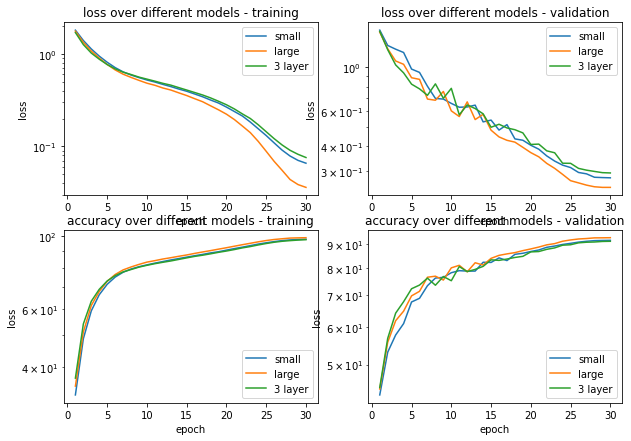

In [16]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2,2,1)
plt.title('loss over different models - training')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale("log")
plt.plot(range(1,31), small_train_loss, label='small')
plt.plot(range(1,31), large_train_loss, label='large')
plt.plot(range(1,31), three_train_loss, label='3 layer')
plt.legend()

plt.subplot(2,2,2)
plt.title('loss over different models - validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale("log")
plt.plot(range(1,31), small_valid_loss, label='small')
plt.plot(range(1,31), large_valid_loss, label='large')
plt.plot(range(1,31), three_valid_loss, label='3 layer')
plt.legend()

plt.subplot(2,2,3)
plt.title('accuracy over different models - training')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale("log")
plt.plot(range(1,31), small_train_acc, label='small')
plt.plot(range(1,31), large_train_acc, label='large')
plt.plot(range(1,31), three_train_acc, label='3 layer')
plt.legend()

plt.subplot(2,2,4)
plt.title('accuracy over different models - validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale("log")
plt.plot(range(1,31), small_valid_acc, label='small')
plt.plot(range(1,31), large_valid_acc, label='large')
plt.plot(range(1,31), three_valid_acc, label='3 layer')
plt.legend()

plt.show()
fig.savefig('model_arch_30.png')